In [5]:
import os
import tifffile
import numpy as np
import pandas as pd
import seaborn_image as isns
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from skimage import feature, morphology
from bigfish import detection

In [6]:
# Assumes the folders are present in the CWD
path_input = "./img_Merscope"
path_output = "./output_Merscope"
path_figures = "./figures_Merscope"
path_fwhm = "./fwhm_Merscope"

paths = os.listdir(path_input)
paths = [p for p in paths if p.endswith(".tif")]
print(paths)

['_DAPI_stack_correct_dimensions_X3970_Y7451_W926_H926.tif', '_LARGE_DAPI_stack_correct_dimensions_X3300_Y7046_W4260_H4260.tif']


In [7]:
np.int = int # Fixes compute_snr_spots using the now deprecated numpy.int https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [8]:
RADIUS_FACTOR = 2.0
PIXEL_SIZE = (700, 108 , 108)  # in nanometer (one value per dimension zyx)
SPOT_RADIUS = (700 * RADIUS_FACTOR, 108 * RADIUS_FACTOR, 108 * RADIUS_FACTOR)  # in nanometer (one value per dimension zyx)
THRESHOLD_LOW = 7000
MIN_DIST= 5
FOOTPRINT = morphology.disk(10) # For white tophat

In [9]:
# Identify peaks as local maxima  and calculate signal to noise ratio with big-fish (https://big-fish.readthedocs.io/en/stable/detection/spots.html#compute-signal-to-noise-ratio)
summary = []
for path in paths:
    img_path = os.path.join(path_input, path)
    img = tifffile.imread(img_path)
    clean_img = np.copy(img)
    clean_img[clean_img < THRESHOLD_LOW] = 0 # Remove all pixels < THRESHOLD_LOW
    clean_img = np.max(clean_img[1:, :], axis = 0) # Skip first plane (out of focus) and do a MIP
    top_img = morphology.white_tophat(clean_img, footprint=FOOTPRINT)
    spots = feature.peak_local_max(clean_img, min_distance=MIN_DIST,
                                   threshold_abs=None,
                                   footprint = None,
                                   threshold_rel=None,
                                   exclude_border=False)  # Identify peaks as local maxima
    # Find the Z coordinate of each peak
    spots = np.pad(spots, ((0, 0), (1 ,0)), 'constant', constant_values = -1)
    for i, spot in enumerate(spots): 
        img_z = img[:, spot[1], spot[2]]
        spots[i, 0] = np.where(img_z == img_z.max())[0][0] 
    output_path = os.path.join(path_output, path.replace(".tif", ".csv"))
    df = pd.DataFrame(spots)
    df.to_csv(path_or_buf = output_path, sep=',', na_rep='', float_format=None, columns=None, header=True, index=False)

    snr = detection.compute_snr_spots(img, spots[:, 0:3], PIXEL_SIZE, SPOT_RADIUS)

    results = {"img_path":img_path, "spots_path":output_path, "spots":spots.shape[0], "snr":snr, "threshold_low":THRESHOLD_LOW}
    summary.append(results)

# Save and print the summary
summary = pd.DataFrame(summary)
print(summary)
summary.to_csv(path_or_buf = os.path.join(path_output, "summary.csv"), sep=',', na_rep='', float_format=None, columns=None, header=True, index=False)   

                                            img_path  \
0  ./img_Merscope/_DAPI_stack_correct_dimensions_...   
1  ./img_Merscope/_LARGE_DAPI_stack_correct_dimen...   

                                          spots_path  spots        snr  \
0  ./output_Merscope/_DAPI_stack_correct_dimensio...     41  26.964072   
1  ./output_Merscope/_LARGE_DAPI_stack_correct_di...    568  24.831152   

   threshold_low  
0           7000  
1           7000  


('./img_Merscope/_DAPI_stack_correct_dimensions_X3970_Y7451_W926_H926.tif', './output_Merscope/_DAPI_stack_correct_dimensions_X3970_Y7451_W926_H926.csv', './figures_Merscope/_DAPI_stack_correct_dimensions_X3970_Y7451_W926_H926-figure.png')
('./img_Merscope/_LARGE_DAPI_stack_correct_dimensions_X3300_Y7046_W4260_H4260.tif', './output_Merscope/_LARGE_DAPI_stack_correct_dimensions_X3300_Y7046_W4260_H4260.csv', './figures_Merscope/_LARGE_DAPI_stack_correct_dimensions_X3300_Y7046_W4260_H4260-figure.png')


<Figure size 640x480 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

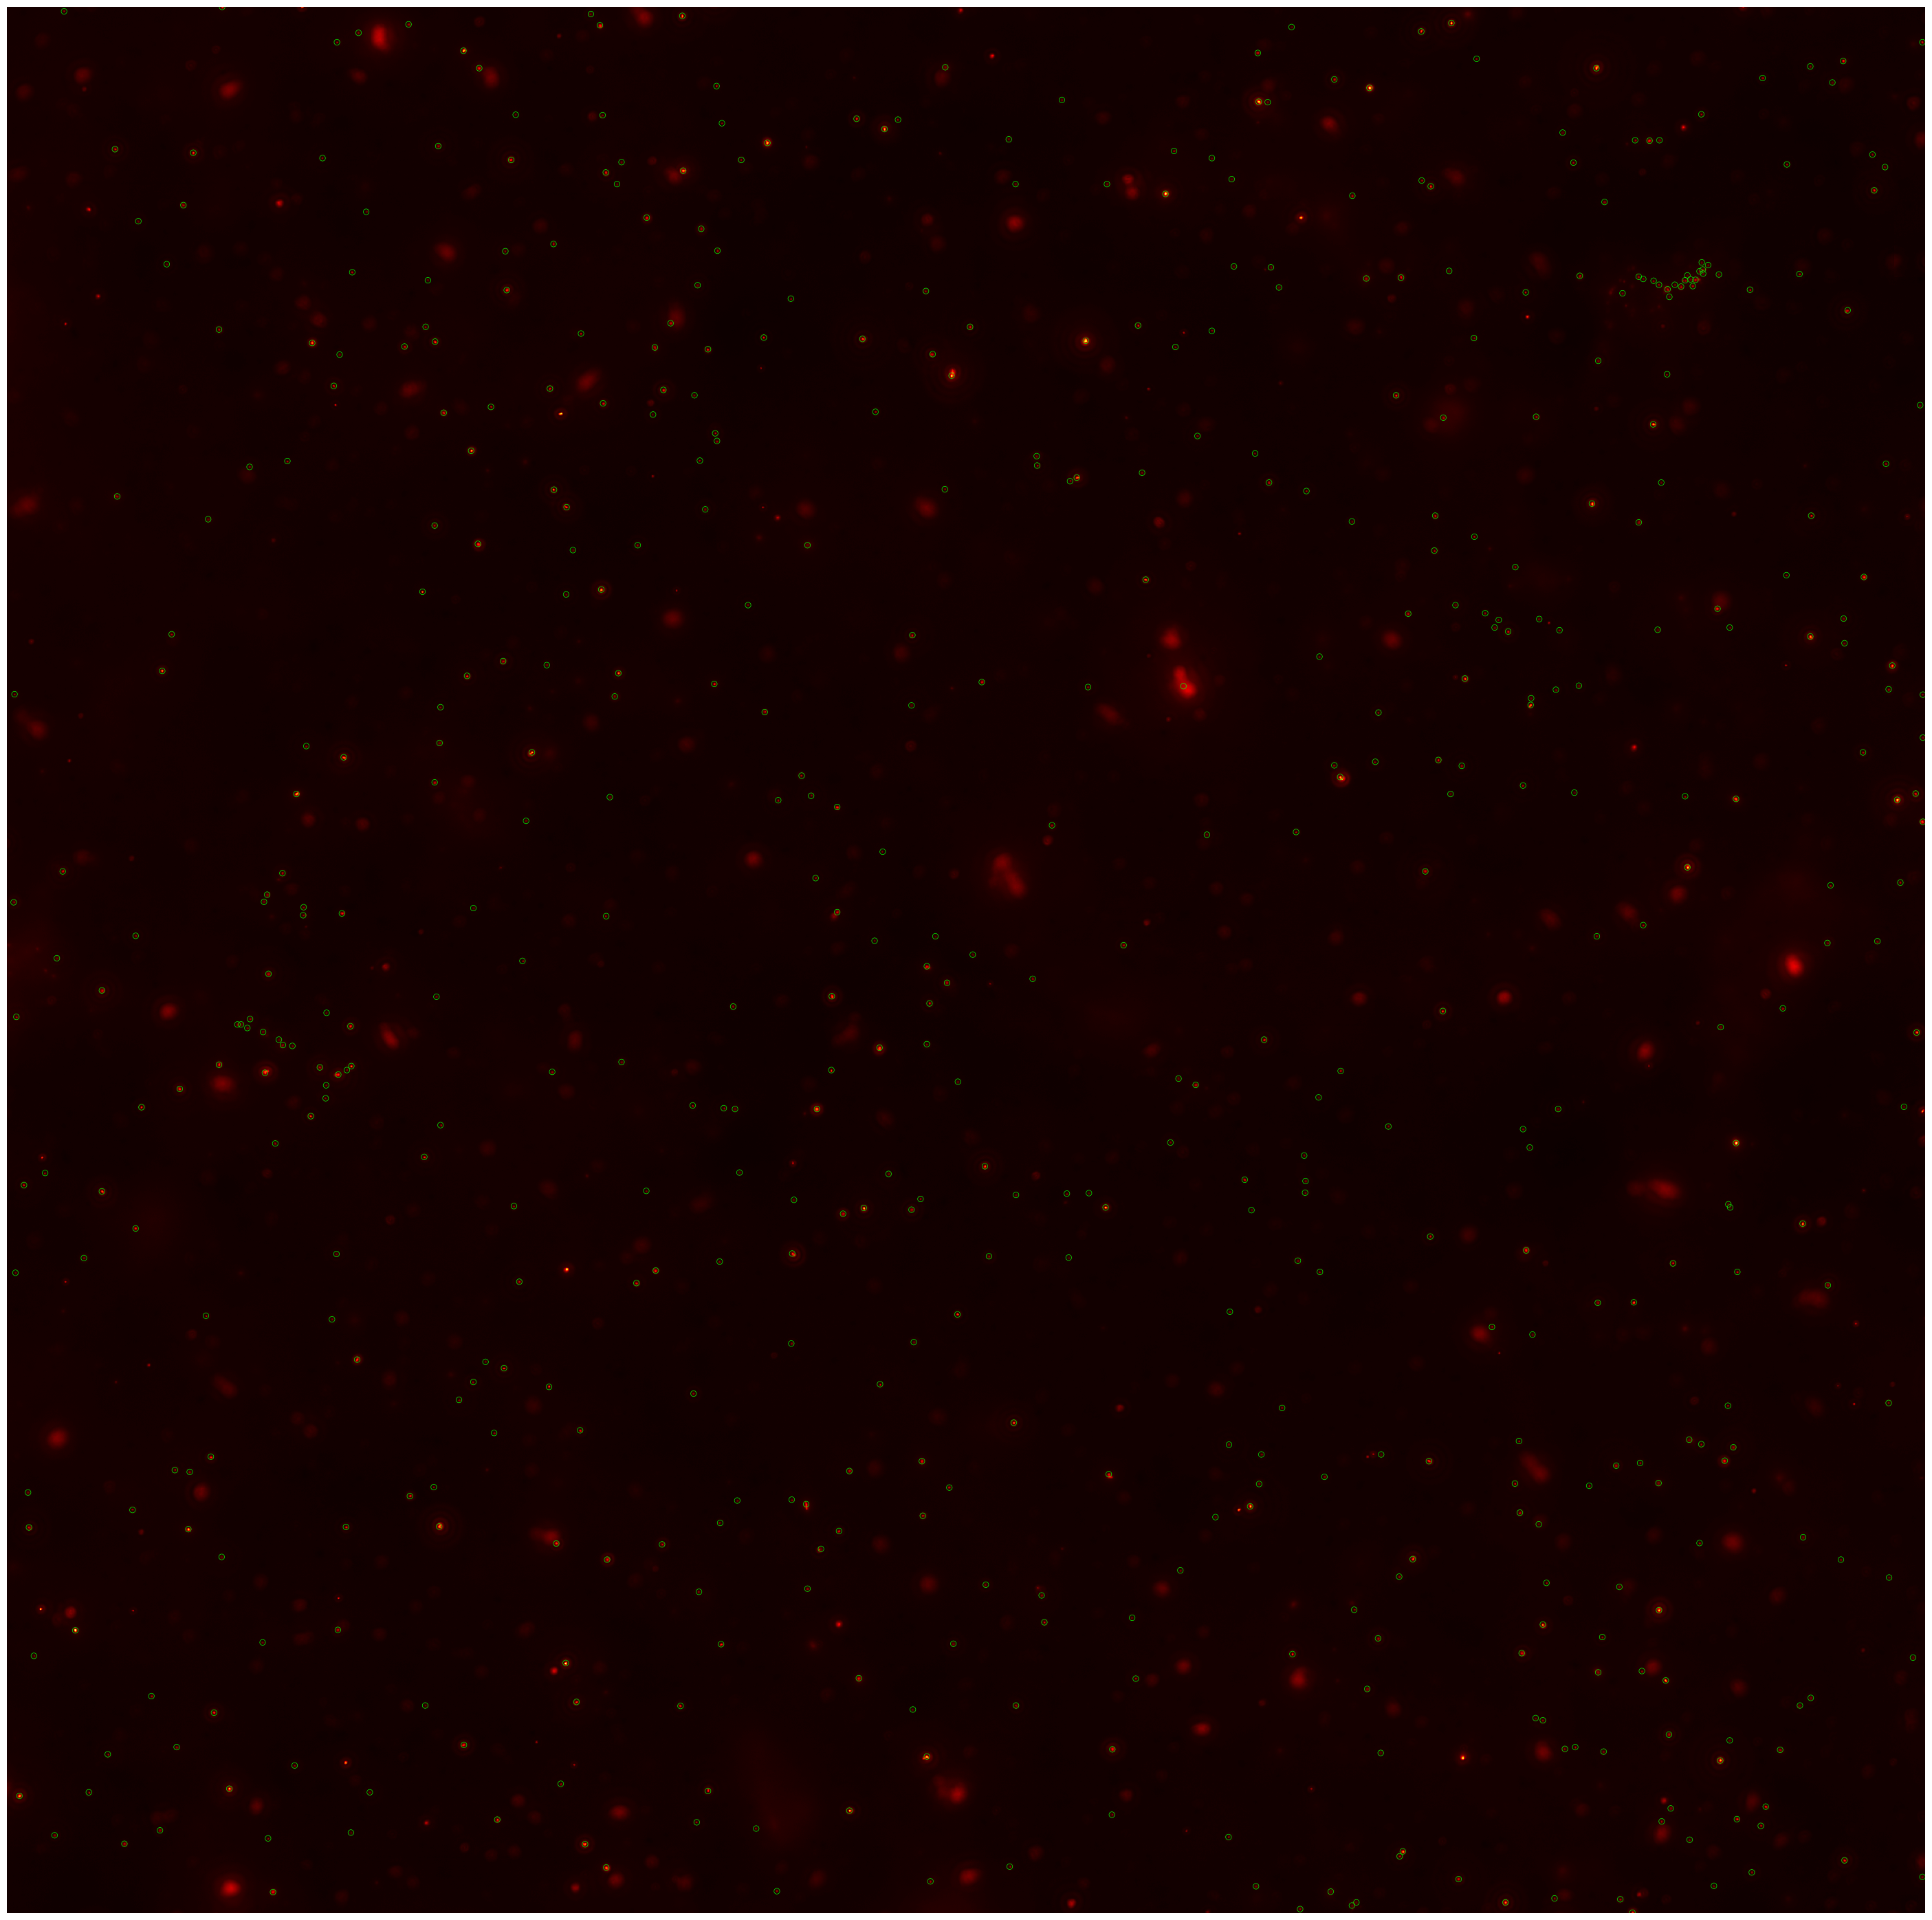

In [10]:
# Plot the identified peaks on the image
for path in paths:
    img_path = os.path.join(path_input, path)
    tbl_path = os.path.join(path_output, path.replace(".tif", ".csv"))
    out_path = os.path.join(path_figures, path.replace(".tif", "-figure.png"))
           
    img = tifffile.imread(img_path)
    img = np.max(img, axis=0)
    
    data = pd.read_csv(tbl_path)
    data.rename(columns = {"1":"y", "2":"x"}, inplace = True)
    data.loc[:, "y"] = img.shape[0] - data.loc[:, "y"]
    plt.clf()
    plt.set_cmap('hot')
    f, ax = plt.subplots(figsize=(36, 36))
    ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], aspect='auto')
    sns.scatterplot(x="x", y="y", facecolors = 'none', edgecolors = 'lime',
                data=data, ax=ax)
    ax.set_axis_off()
    f.savefig(out_path, bbox_inches='tight', pad_inches = 0)
    print((img_path, tbl_path, out_path))

In [11]:
# Calculate FWHM using scipy.signal.peak_widths (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_widths.html)
header = ["z_px", "y_px", "x_px", "z_nm", "y_nm", "x_nm", "fwhm_z_px", "fwhm_y_px", "fwhm_x_px", "fwhm_z_nm", "fwhm_y_nm", "fwhm_x_nm"]
for path in paths:
    img_path = os.path.join(path_input, path)
    tbl_path = os.path.join(path_output, path.replace(".tif", ".csv"))
    out_path = os.path.join(path_fwhm, path.replace(".tif", "-fwhm.csv"))
    img = tifffile.imread(img_path)

    peaks = pd.read_csv(tbl_path)
    peaks = np.asarray(peaks)
    results = np.concatenate((peaks, np.full((peaks.shape[0], 9), -1.0)), axis = 1)
    for i,p in enumerate(peaks):
         results[i,6] = signal.peak_widths(img[: ,p[1], p[2]], np.full((1), p[0]), rel_height=0.5, prominence_data=None, wlen=None)[0]
         results[i,7] = signal.peak_widths(img[p[0], :, p[2]], np.full((1), p[1]), rel_height=0.5, prominence_data=None, wlen=None)[0]
         results[i,8] = signal.peak_widths(img[p[0], p[1], :], np.full((1), p[2]), rel_height=0.5, prominence_data=None, wlen=None)[0]
    results[:, 3] = results[:, 0] * PIXEL_SIZE[0]  
    results[:, 4] = results[:, 1] * PIXEL_SIZE[1]  
    results[:, 5] = results[:, 2] * PIXEL_SIZE[2]  
    results[:, 9] = results[:, 6] * PIXEL_SIZE[0]  
    results[:, 10] = results[:, 7] * PIXEL_SIZE[1]  
    results[:, 11] = results[:, 8] * PIXEL_SIZE[2]  
    
    df = pd.DataFrame(results, columns=header)
    df.to_csv(path_or_buf = out_path, sep=',', na_rep='',
              float_format=None, columns=None, header=True, index=False)


/tmp/ipykernel_79287/2616646643.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[i,6] = signal.peak_widths(img[: ,p[1], p[2]], np.full((1), p[0]), rel_height=0.5, prominence_data=None, wlen=None)[0]
/tmp/ipykernel_79287/2616646643.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[i,7] = signal.peak_widths(img[p[0], :, p[2]], np.full((1), p[1]), rel_height=0.5, prominence_data=None, wlen=None)[0]
/tmp/ipykernel_79287/2616646643.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this 